# 6. 게이트가 추가된 RNN

- RNN은 순환 경로를 포함하며 과거의 정보를 기억할 수 있으며, 구조가 단순하여 구현도 쉽게 할 수 있음.
- 하지만 성능이 좋지 않음
    - 원인 : (많은 경우) 시계열 데이터에서 시간적으로 멀리 떨어진, 장기(long term)의존 관계를 잘 학습할 수 없음
- LSTM, GRU
    - 게이트(gate)라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있음

## 6.1 RNN의 문제점
- 시계열의 장기 의존 관계를 학습하기 어려움. -> BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문

- 장기 기억이 필요한 문제의 예  
Tom was watching TV in his room. Mary came into the room. Mary said hi to ?  
-> 이러한 문제를 풀기 위해서는 장기 의존 관계를 학습해야 함. 하지만 단순한 RNN 계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며(기울기 폭발), 대부분 둘 중 하나의 경우가 일어남

### 기울기 소실과 기울기 폭발의 원인

### 1. tanh(x)
- $y=tanh(x)$에서의 미분 -> $1-y^{2}$ 
- 즉 미분 값이 1.0 이하이고, $x$가 0으로부터 멀어질 수록 작아짐
- 역전파에서는 기울기가 tanh node를 지날 때마다 값은 계속 작아짐


### 2. MatMul
- 같은 가중치 $W_{h}$를 사용하여 계속 업데이트 됨
- 기울기 폭발 혹은 기울기 소멸의 문제가 있음
    - 기울기 폭발이 일어나면 오버플로를 일으켜 NaN 같은 값을 발생
    - 기울기 소실이 일어나면 가중치 매개변수가 더 이상 갱신되지 않으므로, 장기 의존 관계를 학습할 수 없게 됨

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H)

norm_list = []
for t in range(T):
    # norm : 각각의 원소를 제곱해 모두 더하고 제곱근을 취한 값
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

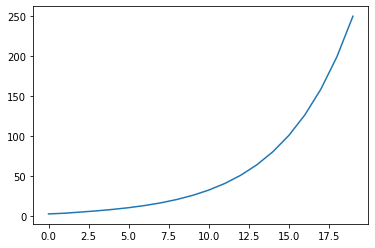

In [2]:
plt.plot(norm_list)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))
np.random.seed(3)
Wh = np.random.randn(H,H) * 0.5

norm_list = []
for t in range(T):
    # norm : 각각의 원소를 제곱해 모두 더하고 제곱근을 취한 값
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

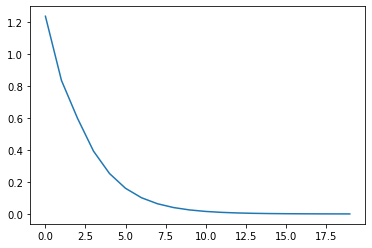

In [4]:
plt.plot(norm_list)

## 기울기 폭발 대책
- **기울기 클리핑(gradient clipping)** : 만약 기울기의 L2 norm이 threshold를 초과하면 기울기를 수정
- $ if ||\hat{g}|| >= threshold :  
            \hat{g} = \frac{threshold}{||\hat{g}||}\hat{g}$
- 이 때 $\hat{g}$는 신경망에서 사용되는 모든 매개변수의 기울기를 하나로 모은 것

In [5]:
import numpy as np
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5

def clip_grads(grads, max_norm):
     # 각각의 뉴런에 대해 연결 가중치가 r을 넘지 않도록 조정
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm/(total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 6.3 기울기 소실과 LSTM(Long short-term Memory)
- 게이트가 추가된 RNN : LSTM, GRU

### LSTM의 인터페이스
- LSTM 계층의 인터페이스에는 c라는 경로가 있다는 차이가 있음
- c : memory cell
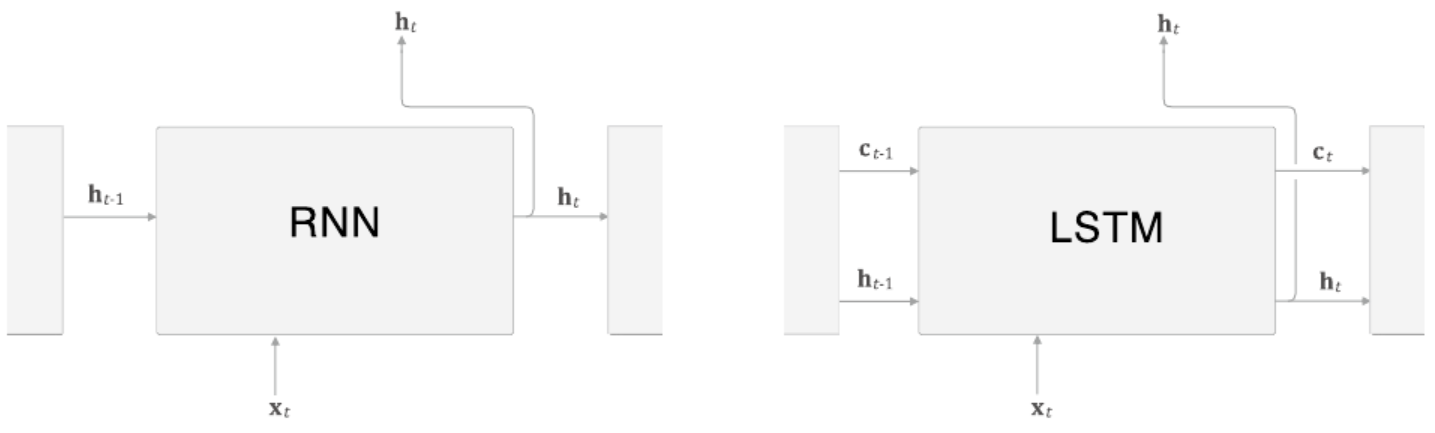

- memory cell은 LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않음
- LSTM의 은닉 상태 h는 RNN 계층과 마찬가지로 다른 계층으로 출력됨

### LSTM 계층 조립하기
- $c_{t-1}$과 $h_{t-1}$을 이용해서 $c_{t}$를 계산. $c_{t}$에 $tanh$함수를 적용한 것이 $h_{t}$
- $c_{t}$에 $tanh$함수를 적용한 것이 $h_{t}$이기 때문에 memory cell인 $c_{t}$와 hidden state $h_{t}$의 원소 수는 같음

### 게이트란?
- 데이터와 기울기 흐름을 적절히 제어(비유하자면 물의 흐름을 제어)
    - 열기/닫기
    - 어느 정도 열지 또한 조정 가능
- 열림 상태를 제어하는 하이퍼파라미터 또한 데이터로부터 학습
    - 0~1사이의 값을 가짐(1 : 완전 개방)
    - sigmoid function 사용

- gate에는 sigmoid function이, 정보를 담는 cell에는 tanh function이 사용됨

### 1. output gate
- $tanh(c_{t})$에 게이트를 적용
- 즉, 그것이 다음 시각의 은닉상태에 얼마나 중요한가를 조정
- $o = \sigma(x_{t}W_{x}^{o}+h_{t-1}W_{h}^{o}+b^{o})$
    - o : output gate의 열림상태를 제어하는 하이퍼파라미터
- $ h_{t} = o . tanh(c_{t}) $ (원소별 곱(아다마르 곱))

### 2. forget gate
- $c_{t-1} $에 게이트를 적용
- 즉, 기억 중 불필요한 기억을 잊게해주는 역할
- $f = \sigma(x_{t}W_{x}^{f}+h_{t-1}W_{h}^{f}+b^{f})$
    - f : forget gate의 열림상태를 제어하는 하이퍼파라미터
- $ c_{t} = f . c_{t-1} $ (원소별 곱(아다마르 곱))

### 3. 새로운 기억
- forget gate를 거치면서 잊어야 할 기억이 삭제되었지만, 새로 기억해야 할 정보를 기억셀에 추가하는 것이 필요
- $g = \tanh(x_{t}W_{x}^{g}+h_{t-1}W_{h}^{g}+b^{g})$
    - g : 새로 기억해야할 정보

### 4. input gate
- $g$에 게이트를 적용
- 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단. 새 정보를 무비판적으로 수용하는 것이 아닌, 적절히 취사선택. 즉 input gate에 의해 가중된 정보가 새로 추가됨.
- $i = \sigma(x_{t}W_{x}^{i}+h_{t-1}W_{h}^{i}+b^{i})$
    - i : 새로운 기억의 열림상태를 제어하는 하이퍼파라미터
- $g = g.i$(원소별 곱(아다마르 곱))
- $c_{t} = c_{t} + g$

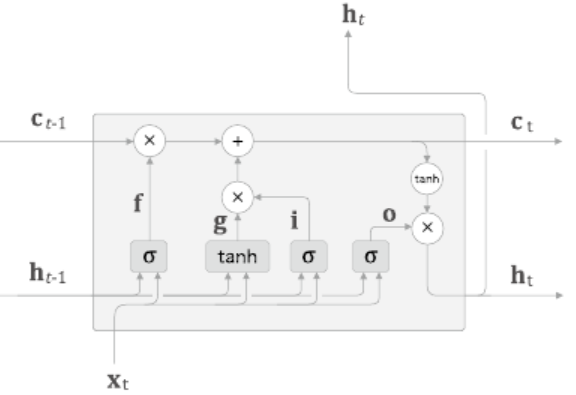

- 이전에는 같은 가중치 행렬로 '행렬곱'을 반복 -> 기울기 소실/폭발
- LSTM의 경우
    1. 매 시각 다른 가중치 행렬을 사용
    2. '행렬곱'이 아닌 '원소별 곱'을 계산
-  forget gate가 '잊어야 한다'고 판단한 memory cell의 원소에 대해서는 그 기울기 값이 작아짐. '잊어서는 안 된다'고 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해짐. 따라서 memory cell의 기울기가 (오래 기억해야 할 정보일 경우) 소실 없이 전파될 수 있음

### LSTM 구현

- Affine
    - $ f = \sigma(x_{t}W_{x}^{f}+h_{t-1}W_{h}^{f}+b^{f})$
    - $ g = \tanh(x_{t}W_{x}^{g}+h_{t-1}W_{h}^{g}+b^{g})$
    - $ i = \sigma(x_{t}W_{x}^{i}+h_{t-1}W_{h}^{i}+b^{i})$
    - $ o = \sigma(x_{t}W_{x}^{o}+h_{t-1}W_{h}^{o}+b^{o})$
- update
    - $ c_{t}  = f.c_{t-1}+g.i$
    - $ h_{t} = o.tanh(c_{t})$

- 4개의 affine transformation을 1번의 affine transformation으로 계산
    - 일반적으로 행렬 라이브러리는 "큰 행렬"을 한꺼번에 계산할 때가 각각을 따로 계산할 때보다 빠르기 때문.
    - 각 $W_{x}, W_{h}, b$는 크기가 모두 같음
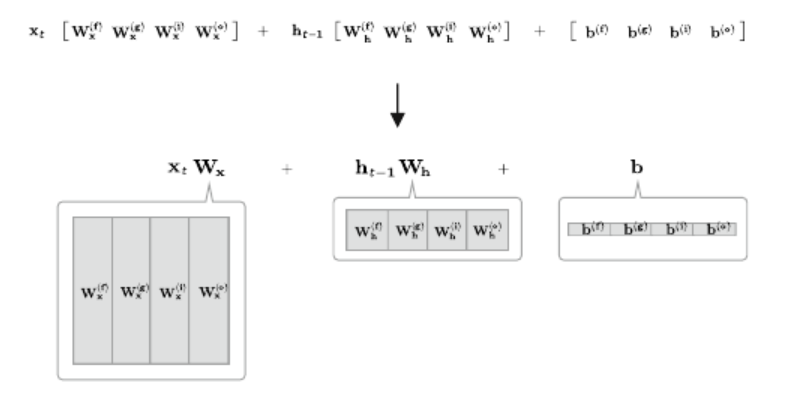

In [ ]:
import numpy as np
import os
import sys
sys.append(os.path.join("..","function"))
from base_function import *
from base_layer import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        # 4개의 가중치가 담겨 있는 초기화 인수
        self.params = [Wx, Wh, b] # RNN과 파라미터 개수는 같지만 그 형상이 다름
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),
                         np.zeros_like(b)]
        # 순전파 때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도의 인스턴스 변수
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        """
        x : 현시각의 입력
        h_prev : 이전 시각의 은닉상태
        c_prev : 이전 시각의 memory cell
        """
        Wx, Wh, b = self.params
        N, H = h_prev.shape     # 이전 시각의 은닉상태의 크기를 기억
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b # 4가지를 행렬곱으로 한번에 계산
        
        # slice
        f = A[:,:H]
        g = A[:,H:2*H]
        i = A[:,2*H:3*H]
        o = A[:,3*H:]
        
        f = sigmoid(f)
        g = tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        # 원소곱을 통한 계산
        c_next = f*c_prev + g*i
        h_next = tanh(c_next)*o
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params # 파라미터 정리
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        # C(t)에 대한 미분
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next*o) * (1-tanh_c_next ** 2) #다른 곳에서의 미분+이후에서의 미분*(tanh미분)
        
        # C(t-1)에 대한 미분
        dc_prev = ds*f
        
        di = ds*g
        df = ds*c_prev
        do = dh_next * tanh_c_next
        dg = ds*i
        
        # slide된 것을 합치기(열방향으로)
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db  = dA.sum(axis=0)
        
        # gradient update
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T) 
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

### TimeLSTM 구현
- Truncated BPTT(backpropagation trough time)로 구현
    - 순전파는 완전 연결, 역전파는 적당한 곳에서 끊음
    - 끊어지기 때문에 인스턴스 변수로 memory cell과 hidden state를 저장해둠
- 각 time 마다의 $W_{h}, W_{x}, b$(4가지 affine을 위한 연산을 한번에 모은 가중치)는 모두 동일

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b] # 파라미터 저장
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # grads
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # batch size, time size, feature size
        H = Wh.shape[0] # 새로 만들 feature size
        
        self.layers = []
        hs = np.empty((N,T,H), dtype="f") # 각 time의 hs를 만듦(다음 affine 층으로 보내기 위해 필용)
        
        if not self.stateful or self.h is None: # 상태 유지 X or 아예 처음(self.h가 없다면)
            self.h = np.zeros((N,H), dtype="f") # 넘어오는 self.h의 원소를 모두 0으로 설정
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H), dtype="f") # memory cell과 hidden state의 크기는 같음
            
        for t in range(T):
            layer = LSTM(*self.params) # 각 time마다의 가중치는 모두 동일
            self.h, self.c = layer.forward(xs[:,t,:],self.h, self.c) # hidden state, memory cell 갱신
            hs[:,t,:] = self.h # 각 time의 hidden state 저장
            
            self.layers.append(layer) # layer을 쌓아올림
            
        return hs 
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N,T,D), dtype="f")
        dh, dc = 0, 0 # 역전파는 적당한 길이로 끊기 때문
        
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # 다음 layer층에서 올라온 dhs. 다음 time에서 온 dh
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
            # 모든 time에서의 grad를 한 곳에 합침
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad # grad를 저장
        self.dh = dh # 이전 timelstm에서 사용될 수 있기 때문에 저장해둠
        return dxs # 이전 layer 층을 위해 반환
    
    def set_state(self,h,c=None):
        self.h, self.c = h,c
        
    def reset_state(self): # test data로 평가할 시에 필요
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어모델

In [ ]:
import sys
sys.path.append(".")
from function.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size = 10000, wordvec_size = 100, hidden_size = 100):
        """
        vocab_size : 총 word 개수(중복 X)
        wordvec_size : embedding size
        hidden size : hidden state column size
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn # 더 편하게 사용하기 위해 rn 으로 바꿈
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype("f") # 표준편차 1/100으로 설정
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype("f") # xavier 초기화
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype("f") # xavier 초기화
        lstm_b = np.zeros(4*H).astype("f")
        affine_W = (rn(H,V) / np.sqrt(H)).astype("f") # 각 단어가 나올 확률 최종 출력
        affine_b = np.zeros(V).astype("f")
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1] # lstm layer을 따로 저장(state 정의를 위해)
        
        # 모든 가중치와 기울기를 리스트에 모음
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self): # test data로 평가할 시에 필요
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name = "Rnnlm.pkl"):
        with open(file_name, "wb") as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name = "Rnnlm.pkl"):
        with open(file_name, "rb") as f:
            self.params = pickle.load(f)

In [ ]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
from optimizer import SGD
from RnnlmTrainer import *
from common.util import eval_perplexity
from dataset import ptb
from Rnnlm import Rnnlm

# 하이퍼파라미터 설정
batch_size = 20 
wordvec_size = 100 # word vector 크기
hidden_size = 100  # hidden state 크기
time_size = 35     # RNN을 펼치는 크기
lr = 0.1           # learning rate
max_epoch = 4
max_grad  = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_test, _, _ = ptb.load_data("test")
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, # max_grad을 이용하여 기울기 클리핑
           eval_interval = 20) # 20번의 반복마다 퍼블렉서티 출력
trainer.plot(ylim = (0,500))

# 테스트 데이터로 평가
model.reset_state() # test data이기 때문에 reset 해줌
# 이 모델을 적용하였을 때, 해당 test 문장이 나올 확률을 계산
ppl_test = eval_perplexity(model, corpus_test)
print("테스트 퍼플렉서티", ppl_test)

# 매개변수 저장
model.save_params()

## 6.5 RNNLM 추가 개선

### 1. LSTM 계층 다층화
- LSTM layer을 여러개 쌓음으로써 더 복잡한 패턴을 학습할 수 있게 함.
- 이 때, layer을 몇 층 쌓을지는 하이퍼파라미터에 관한 문제.
    - 처리할 문제의 복잡도나 준비된 학습 데이터의 양에 따라 적절하게 결정하여야 함.
    - 복잡하고 학습 데이터 양이 많다면 '깊게'쌓는 것이 정확도 향상을 이끌 수 있음

### 2. 드롭아웃에 의한 과적합 억제
- RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킴. 따라서 RNN의 과적합 대책은 중요하고, 현재도 활발하게 연구되는 주제.
#### 과적합 억제 방법
1. 훈련 데이터 양 증가시키기
2. 모델의 복잡도 감소시키기
3. 정규화
4. **드롭아웃(Dropout)**

### Dropout 적용 방법
1. LSTM 계층의 시계열 방향으로 Dropout을 삽입.
    - 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적. 시간의 흐름에 따라 정보가 사라질 수 있음
2. LSTM 계층의 깊이 방향(상하 방향)으로 삽입

### Variational Dropout(변형 드롭아웃)
- 시간 방향으로 Dropout을 적용하면서도, 시간의 흐름에 따라 노이즈가 축적되는 문제를 해결하기 위해 등장한 Dropout 기법
- 깊이 방향은 물론, 시간방향에도 이용할 수 있어서 언어 모델의 정확도를 향상시킬 수 있음

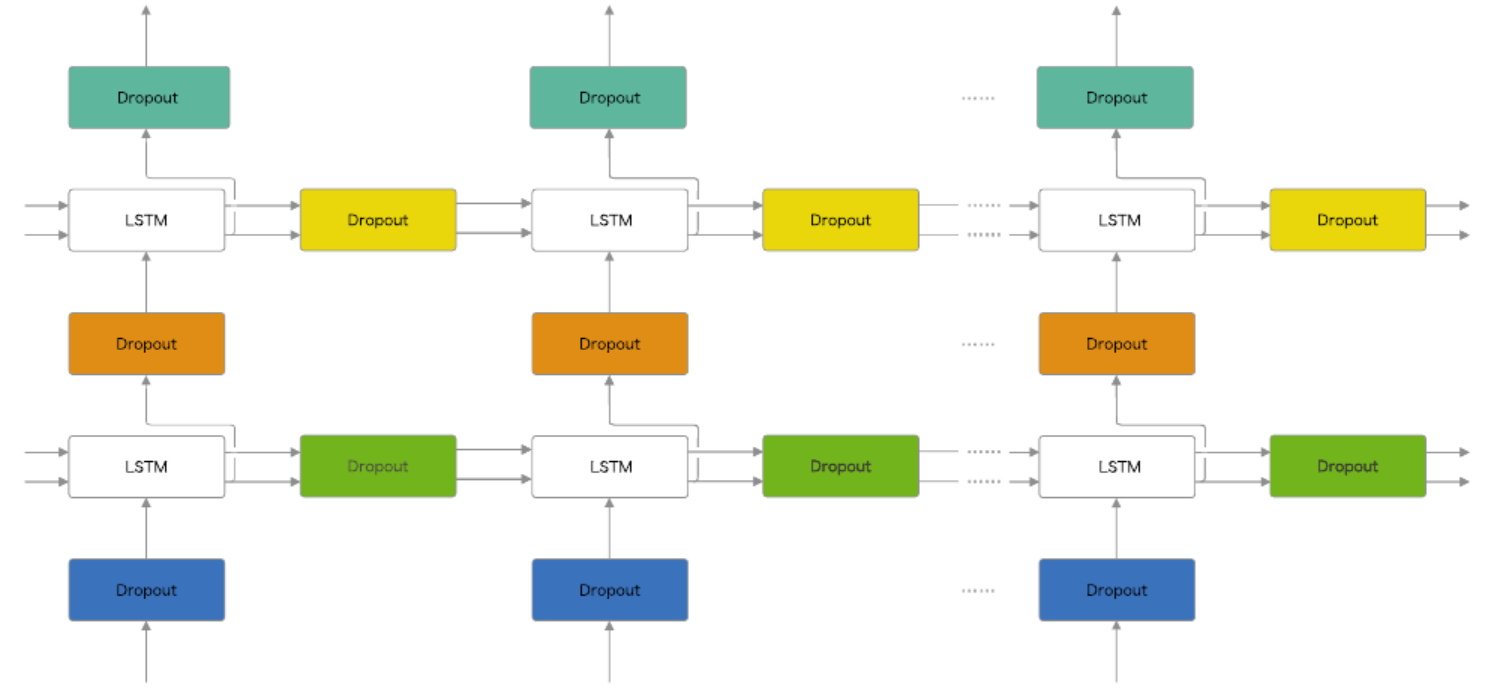

- 같은 계층의 드롭아웃끼리 '마스크'를 공유함으로써 마스크가 '고정'됨. 그 결과 정보를 잃게 되는 방법도 '고정'되므로, 일반적인 드롭아웃 때와 달리 정보가 지수적으로 손실되는 사태를 피할 수 있음
    - 마스크 : 데이터의 '통과/차단'을 결정하는 이진(binary)형태의 무작위 패턴
- 일반적으로 일반 드롭아웃보다 결과가 좋음

### 3. 가중치 공유
- Embedding 계층의 가중치와 Affine 계층의 가중치를 연결하는(공유하는) 기법
- NxT -> NxTxD -> NxTxH -> NxTxV
- Embedding layer weight size : VxD(D를 H와 같은 값으로 설정해줌)
- Affine layer weight size    : HxV
- Embedding layer의 가중치를 전치하여 Affine layer의 가중치로 설정.

- 학습할 매개변수의 수를 줄일 수 있음
    - 학습하기가 더 쉬워짐
    - 과적합(overfitting)의 억제 효과

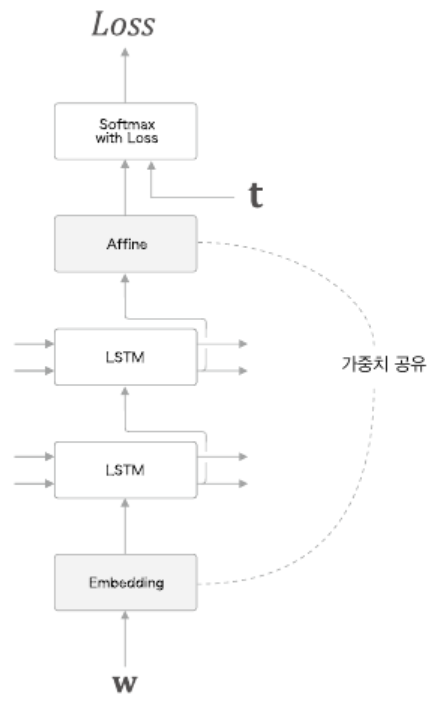

### 4. 개선된 RNNLM 구현
- LSTM 계층의 다층화(2층) -> 다양한 관계 표현
- 드롭아웃(dropout) 사용(깊이 방향으로만) -> 일반화
- 가중치 공유(Embedding layer와 Affine layer에서의) -> 가중치를 효율적으로 이용

In [3]:
import sys
import os
sys.path.append(os.path.join("..","master"))
sys.path.append(os.path.join("..","function"))
from time_layers import *
from common.np import *
from common.base_model import BaseModel
import numpy as np

class BetterRnnlm(BaseModel): # params save/load와 같은 함수 상속받음
    def __init__(self, vocab_size = 10000, wordvec_size = 650,
                hidden_size = 650, dropout_ratio = 0.5):
        """
        vocab size    : 총 단어 수(중복 X)
        wordvec_size  : embedding size(가중치 공유 시 hidden size와 같아야 함)
        hidden size   : LSTM weight size
        dropout_ratio : dropout 비율
        """
        V,D,H = vocab_size, wordvec_size, hidden_size
        rn = random.randn

        # 가중치를 공유하기 때문에 Affine weight를 정의하지 않음
        embed_W = (rn(V,D)/100).astype("f")
        lstm_Wx1 = (rn(D, 4*H)/np.sqrt(D)).astype("f")
        lstm_Wh1 = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_b1 = np.zeros(4*H).astype("f")
        lstm_Wx2 = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_Wh2 = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_b2 = np.zeros(4*H).astype("f")
        affine_b = np.zeros(V).astype("f")

        # 세가지 개선!
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]] # reset h를 위해
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs, train_flg = False):
        # train_flg에 따라 dropout을 실행할지 안할지 선언해놓음
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

-> 매 epoch에서 검증 데이터로 퍼플렉서티를 평가하고, 그 값이 나빠졌을 경우에만 학습률을 낮춤.


In [ ]:
import sys
import os
sys.path.append(os.path.join("..","master"))
sys.path.append(os.path.join("..","function"))
from time_layers import *
from common.np import *
from common.base_model import BaseModel
import numpy as np

from common import config
from optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from better_rnnlm import BetterRnnlm

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_val, _, _ = ptb.load_data("val")
corpus_test, _, _ = ptb.load_data("test")

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float("inf") # 기존 퍼플렉서티

for epoch in range(max_epoch):
    trainer.fit(xs,ts,max_epoch = 1, batch_size = batch_size,
               time_size = time_size , max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print("검증 퍼플렉서티 : ", ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
    
    model.reset_state()
    print("-"*50)

### 5. 첨단연구들
- 다층 LSTM 사용, dropout 기반의 정규화 수행(엄밀히 말하면 변형 dropout, DropConnect), 가중치 공유의 기법은 동일
    - DropConnect : 가중치 자체를 무작위로 무시하는 기법
- attention 사용